In [1]:
import pandas as pd

import numpy as np
from numpy.polynomial import Polynomial
from numpy.polynomial.polynomial import polyval

import stats

from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns

import os

from IPython.utils import io

from utils import get_occ_dfs, get_hmmconf_df, get_bp_df
import validation
from validation import get_dataset_metrics, extract_filename, plot_bar_chart_comparison_, get_statistics, print_stat, print_procentual

In [2]:
INPUT_DIR = os.path.join('..','output')
PREFIX_ALIGN_DIR = os.path.join(INPUT_DIR, 'prefix-alignment')
PREFIX_W_1_DIR = os.path.join(PREFIX_ALIGN_DIR, 'window-size-1')
PREFIX_W_INF_DIR = os.path.join(PREFIX_ALIGN_DIR, 'window-size-maximum')
HMMCONF_DIR = os.path.join(INPUT_DIR,'hmmconf')
C_3PA_DIR = os.path.join(INPUT_DIR,'C-3PO','test_avg_trace_length')
OLD_OCC_DIR = os.path.join(INPUT_DIR,'C-3PO','old_occ')
BP_DIR = os.path.join(INPUT_DIR,'bp')

LOGS = ["BPI_2017","BPI_2012","M1","M2","M3","M4","M5","M6","M7","M8","M9","M10"]
LOG_TYPES = ['completeness20', 'completeness50', 'sim']
COMPLETENESS_LOGS = ['completeness20','completeness50']

In [3]:
#!jt -t grade3
#!jt -t chesterish
#jupyter nbconvert --to webpdf --no-input .\analysis.ipynb

## Datasets
note: Kristo can share his insights
- completeness logs
- regular logs
- model types

#### Logs overview
##### BPI proxy logs:

These proxy logs are used in the validation of completeness:
- BPI_2012_frequencyLog.xml
- BPI_2017_frequencyLog.xml

Thse proxy logs are used in the comparison evaluation:
- BPI_2017_Sim_2k_random_0.95.xes
- BPI_2012_Sim_2k_random_0.95.xes

There is no difference in alignment cost between the configurations (IWS, ws root state, and ws all states) when I use the BPI_XXXX_Sim_2k_random_0.95.xes proxy logs.

When I use the frequencyLog as proxy log for the comparison between state of the art OCC algorithms - the conformance cost of the BPI_XXXX logs is incompatible with the algorithms to a degree where the i.e correlation with the algorithms changes drastically and the p value deems some correlations statistically insignificant. Thus I used the Sim_2k_random as proxy logs for the comparison experiments.

## Preprocessing

In [4]:
from IPython.utils import io

occ_output_dirs = [C_3PA_DIR, PREFIX_W_1_DIR, PREFIX_W_INF_DIR, HMMCONF_DIR, BP_DIR]
with io.capture_output() as captured:
    C_3PA_LOGS = ["BPI_2017","BPI_2012","M1","M2","M3","M4","M5","M6","M7","M8","M9","M10"]
    C_3PA_df = get_occ_dfs(occ_output_dirs[0], C_3PA_LOGS, True)

    PREF_W_1_LOGS = ["BPI_2017","BPI_2012","M1","M2","M4","M8","M9"]
    pref_w_1_df = get_occ_dfs(occ_output_dirs[1], PREF_W_1_LOGS)

    PREF_W_INF_LOGS = ["BPI_2017","BPI_2012","M1","M2","M4","M8","M9"]
    pref_w_inf_df = get_occ_dfs(occ_output_dirs[2], PREF_W_INF_LOGS)

    HMMCONF_LOGS = ["BPI_2017","BPI_2012","M1","M2","M4","M8","M9"]
    hmmconf_df = get_hmmconf_df(occ_output_dirs[3], HMMCONF_LOGS)

    BP_LOGS = ["BPI_2017","BPI_2012","M1","M2","M8"]
    BP_df = get_bp_df(occ_output_dirs[4], BP_LOGS)

In [5]:
print("3PO")
print(C_3PA_df.info())
print(80*"_")

3PO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TraceId            21000 non-null  int64  
 1   TraceLength        21000 non-null  int64  
 2   Conformance cost   21000 non-null  float64
 3   Completeness cost  21000 non-null  float64
 4   Confidence cost    21000 non-null  float64
 5   ExecutionTime      21000 non-null  float64
 6   model              21000 non-null  object 
 7   log_type           21000 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 1.3+ MB
None
________________________________________________________________________________


In [6]:
print("W-1")
print(pref_w_1_df.info())
print(80*"_")

W-1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TraceId           13500 non-null  int64  
 1   Conformance cost  13500 non-null  float64
 2   ExecutionTime     13500 non-null  float64
 3   model             13500 non-null  object 
 4   log_type          13500 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 527.5+ KB
None
________________________________________________________________________________


In [7]:
print("W-inf")
print(pref_w_inf_df.info())
print(80*"_")

W-inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TraceId           13500 non-null  int64  
 1   Conformance cost  13500 non-null  float64
 2   ExecutionTime     13500 non-null  float64
 3   model             13500 non-null  object 
 4   log_type          13500 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 527.5+ KB
None
________________________________________________________________________________


In [8]:
print("hmmconf")
print(hmmconf_df.info())
print("Traces total: {}".format(hmmconf_df.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).shape[0]))
print(80*"_")

hmmconf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57887 entries, 0 to 57886
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TraceId            57887 non-null  float64
 1   ExecutionTime      57887 non-null  float64
 2   emitconf           57887 non-null  float64
 3   stateconf          57887 non-null  float64
 4   finalconf          57887 non-null  float64
 5   injected_distance  57887 non-null  float64
 6   completeness       57887 non-null  float64
 7   model              57887 non-null  object 
 8   log_type           57887 non-null  object 
dtypes: float64(7), object(2)
memory usage: 4.0+ MB
None
Traces total: 2610
________________________________________________________________________________


In [9]:
print("BP")
print(BP_df.info())
print("Traces total: {}".format(BP_df.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).shape[0]))
print(80*"_")

BP
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206418 entries, 0 to 206417
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TraceId        206418 non-null  int32  
 1   activityId     206418 non-null  object 
 2   conformance    206418 non-null  float64
 3   completeness   206418 non-null  float64
 4   confidence     206418 non-null  float64
 5   ExecutionTime  206418 non-null  float64
 6   model          206418 non-null  object 
 7   log_type       206418 non-null  object 
dtypes: float64(4), int32(1), object(3)
memory usage: 11.8+ MB
None
Traces total: 10500
________________________________________________________________________________


In [10]:
print("C_3PA_df")
print(C_3PA_df[['Completeness cost', 'Conformance cost', 'Confidence cost', 'ExecutionTime']].describe())
print(80*"_")

C_3PA_df
       Completeness cost  Conformance cost  Confidence cost  ExecutionTime
count       21000.000000      21000.000000      21000.00000   21000.000000
mean            3.667286         20.462476         12.60300     164.961171
std             6.057687         17.256273         15.57984     463.397686
min             0.000000          0.000000          0.00000       0.000000
25%             0.000000          8.000000          0.00000       0.000000
50%             1.000000         17.000000          7.00000       0.400000
75%             5.000000         28.000000         21.00000      19.600000
max            52.000000        229.000000        114.00000    7140.000000
________________________________________________________________________________


In [11]:
print("pref_w_1_df")
print(pref_w_1_df[['Conformance cost', 'ExecutionTime']].describe())
print(80*"_")

pref_w_1_df
       Conformance cost  ExecutionTime
count      13500.000000    13500.00000
mean          18.308296       52.99117
std           13.809845      328.98143
min            0.000000        0.00000
25%            8.000000        1.00000
50%           15.000000        9.00000
75%           25.000000       27.05000
max          167.000000    18745.80000
________________________________________________________________________________


In [12]:
print("pref_w_inf_df")
print(pref_w_inf_df[['Conformance cost', 'ExecutionTime']].describe())
print(80*"_")

pref_w_inf_df
       Conformance cost  ExecutionTime
count      13500.000000   13500.000000
mean          15.679481      93.575822
std           12.273799     564.314328
min            0.000000       0.000000
25%            7.000000       3.400000
50%           12.000000      14.600000
75%           21.000000      48.600000
max          162.000000   31814.800000
________________________________________________________________________________


In [13]:
print("hmmconf")
print(hmmconf_df[['ExecutionTime', 'finalconf', 'injected_distance', 'completeness']].describe())
print(80*"_")

hmmconf
       ExecutionTime     finalconf  injected_distance  completeness
count   57887.000000  57887.000000       57887.000000  57887.000000
mean        0.170401      0.471245          16.133329      0.633755
std         0.719483      0.406406          28.334374      0.251678
min         0.000000      0.000000           0.000000      0.111111
25%         0.000000      0.090550           2.000000      0.400000
50%         0.000000      0.373504           7.000000      0.666667
75%         0.000000      0.980377          16.000000      0.846154
max        42.486520      1.000000         419.000000      1.000000
________________________________________________________________________________


In [14]:
print("BP_df")
print(BP_df[['ExecutionTime', 'conformance', 'completeness', 'confidence']].describe())
print(80*"_")

BP_df
       ExecutionTime    conformance   completeness     confidence
count  206418.000000  206418.000000  206418.000000  206418.000000
mean        0.001917       0.374243       0.693455       0.657628
std         0.034577       0.178135       0.287139       0.235074
min         0.000220       0.000000       0.000000       0.000000
25%         0.000900       0.250000       0.476190       0.520000
50%         0.001140       0.361667       0.771429       0.680000
75%         0.001480       0.487968       1.000000       0.840000
max         6.432220       1.000000       1.000000       1.000000
________________________________________________________________________________


## Validation

In [15]:
dims_14 = {'conf': 1, 'trace_length': 2, 'time': 3}
avg_costs_14 = {'conf': [], 'trace_length': [], 'time': []}

dims_25 = {'conf': 1, 'compl': 2, 'confi': 3, 'total': 4, 'trace_length': 5, 'time': 6}
avg_costs_25 = {'conf': [], 'compl': [], 'confi': [], 'total': [], 'trace_length': [], 'time': []}

no_compl_no_conf_dict, dict_keys = get_dataset_metrics(
   INPUT_DIR+"/tripleocc_runs/no_compl_no_conf", dims=dims_14, avg_costs=avg_costs_14, regex_f=extract_filename)
# no_compl_avg_dict, _ = get_dataset_metrics(
#     INPUT_DIR+"/tripleocc_runs/no_compl_avg", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
# no_compl_min_dict, _ = get_dataset_metrics(
#     INPUT_DIR+"/tripleocc_runs/no_compl_min", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
no_conf_ws_root_dict, dict_keys_ = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_conf_ws_root", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
no_conf_ws_all_states_dict, _  = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_conf_ws_all_compressed", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)

### Completeness

In [16]:
no_compl_no_conf_compl_stats=get_statistics(no_compl_no_conf_dict, validation.completeness_output)
no_conf_ws_all_stats=get_statistics(no_conf_ws_all_states_dict, validation.completeness_output)
no_conf_ws_root_stats=get_statistics(no_conf_ws_root_dict, validation.completeness_output)

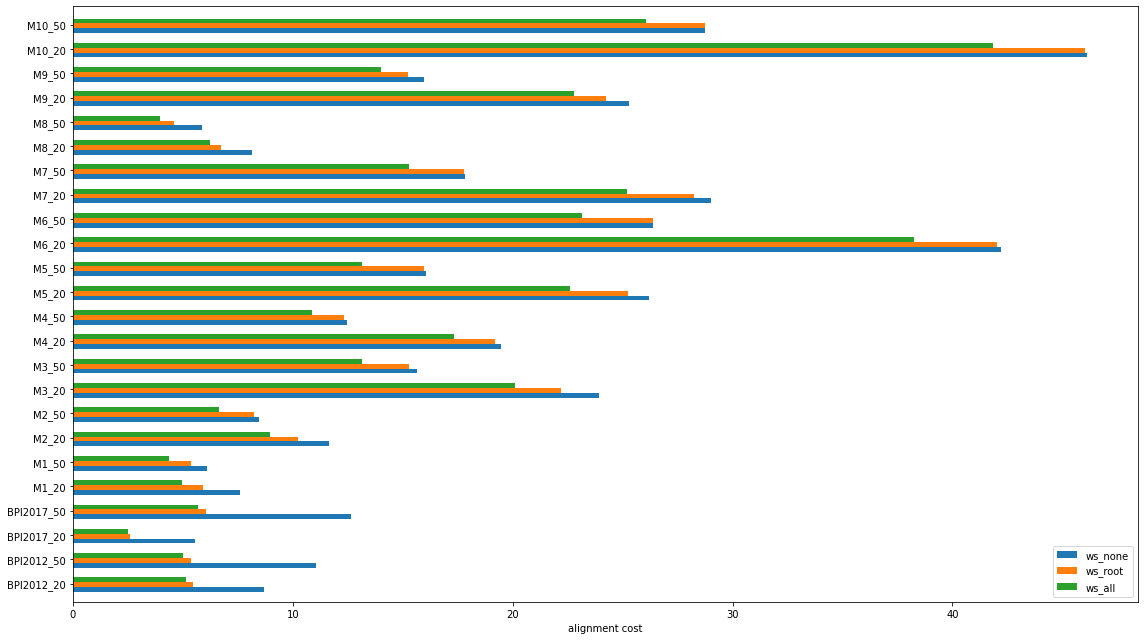

ws root stats:
ws root: mean mean all logs 16.641 - IWS: mean mean all logs 17.961
ws root: mean std all logs 9.803 - IWS: mean std all logs 9.461
Decrease % in conformance: -7.349
--------------------------------------------------------------------------------
ws all stats:
ws all: mean mean all logs 14.886 - IWS: mean mean all logs 17.961
ws all: mean std all logs 9.114 - IWS: mean std all logs 9.461
Decrease % in conformance: -17.12


<Figure size 432x288 with 0 Axes>

In [17]:
"""Grouped bar chart - ws root"""
plt.rcParams.update({'font.size': 22})
plot_bar_chart_comparison_(validation.completeness_labels, no_compl_no_conf_compl_stats,
                            no_conf_ws_root_stats, no_conf_ws_all_stats,'mean', ['ws_none', 'ws_root', 'ws_all'], "alignment cost", "avg alignment cost pr log")

print("ws root stats:")
print_stat('mean', no_conf_ws_root_stats, no_compl_no_conf_compl_stats, "ws root", "IWS")
print_stat('std', no_conf_ws_root_stats, no_compl_no_conf_compl_stats,  "ws root", "IWS")
print(print_procentual('mean','conformance',no_conf_ws_root_stats, no_compl_no_conf_compl_stats))
print(40*"--")
print("ws all stats:")
print_stat('mean', no_conf_ws_all_stats, no_compl_no_conf_compl_stats, "ws all", "IWS")
print_stat('std', no_conf_ws_all_stats, no_compl_no_conf_compl_stats,  "ws all", "IWS")
print(print_procentual('mean','conformance',no_conf_ws_all_stats, no_compl_no_conf_compl_stats))
plt.savefig("images/avg alingment cost pr log - completeness.pdf")
#plt.show()
#plt.close()

##### Mean execution time comparison

In [18]:
# from sklearn.preprocessing import MinMaxScaler

# data_dicts = [no_compl_no_conf_dict, no_conf_ws_all_states_dict, no_conf_ws_root_dict]
# for log in validation.completeness_output:
#     scaler = MinMaxScaler()
#     scaler.fit(np.asarray(no_compl_no_conf_dict[log]['time'] + no_conf_ws_all_states_dict[log]['time'] + no_conf_ws_root_dict[log]['time']).reshape(-1,1))
#     for dict_ in data_dicts:
#         dict_[log]['time'] = scaler.transform(np.asarray(dict_[log]['time']).reshape(-1,1)).flatten()

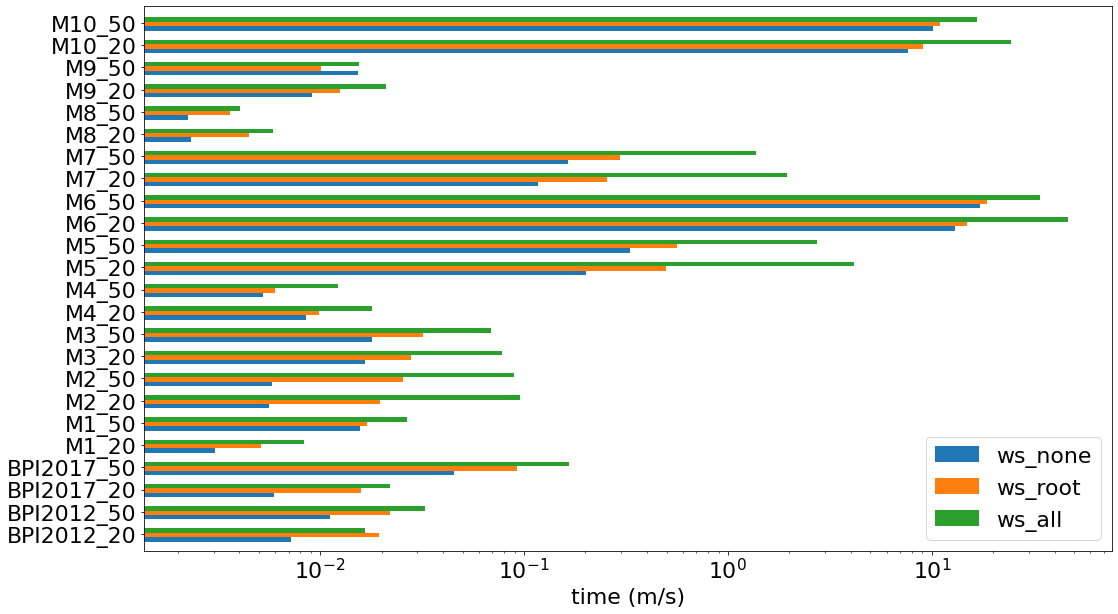

ws root stats:
ws root: mean time all logs 2.307 - IWS: mean time all logs 2.048
ws root: mean time_std all logs 0.753 - IWS: mean time_std all logs 0.557
--------------------------------------------------------------------------------
ws all stats:
ws all: mean time all logs 5.523 - IWS: mean time all logs 2.048
ws all: mean time_std all logs 2.531 - IWS: mean time_std all logs 0.557
--------------------------------------------------------------------------------
ws_root time comparison with standard - Increase % in time: 12.646
ws_all time comparison with standard - Increase % in time: 169.678
ws_all time comparison with ws_root - Increase % in time: 139.402


<Figure size 432x288 with 0 Axes>

In [19]:
plt.rcParams.update({'font.size': 22})
plot_bar_chart_comparison_(validation.completeness_labels, no_compl_no_conf_compl_stats,
                          no_conf_ws_root_stats, no_conf_ws_all_stats,'time', ['ws_none', 'ws_root', 'ws_all'], "time (m/s)", "avg miliseconds pr event in log", True)
print("ws root stats:")
print_stat('time', no_conf_ws_root_stats, no_compl_no_conf_compl_stats, "ws root", "IWS")
print_stat('time_std', no_conf_ws_root_stats, no_compl_no_conf_compl_stats,  "ws root", "IWS")
print(40*"--")
print("ws all stats:")
print_stat('time', no_conf_ws_all_stats, no_compl_no_conf_compl_stats, "ws all", "IWS")
print_stat('time_std', no_conf_ws_all_stats, no_compl_no_conf_compl_stats,  "ws all", "IWS")
print(40*"--")
print("ws_root time comparison with standard - "+print_procentual('time','time',no_conf_ws_root_stats, no_compl_no_conf_compl_stats))
print("ws_all time comparison with standard - "+print_procentual('time','time',no_conf_ws_all_stats, no_compl_no_conf_compl_stats))
print("ws_all time comparison with ws_root - "+print_procentual('time','time',no_conf_ws_all_stats, no_conf_ws_root_stats))

plt.savefig("images/avg miliseconds pr event in log - completeness.pdf")
#plt.show()
#plt.close()

#### Completeness all logs

In [20]:
no_compl_no_conf_compl_stats = get_statistics(no_compl_no_conf_dict, validation.normal_output)
no_conf_ws_root_stats = get_statistics(no_conf_ws_root_dict, validation.normal_output)
no_conf_ws_all_stats = get_statistics(no_conf_ws_all_states_dict, validation.normal_output)

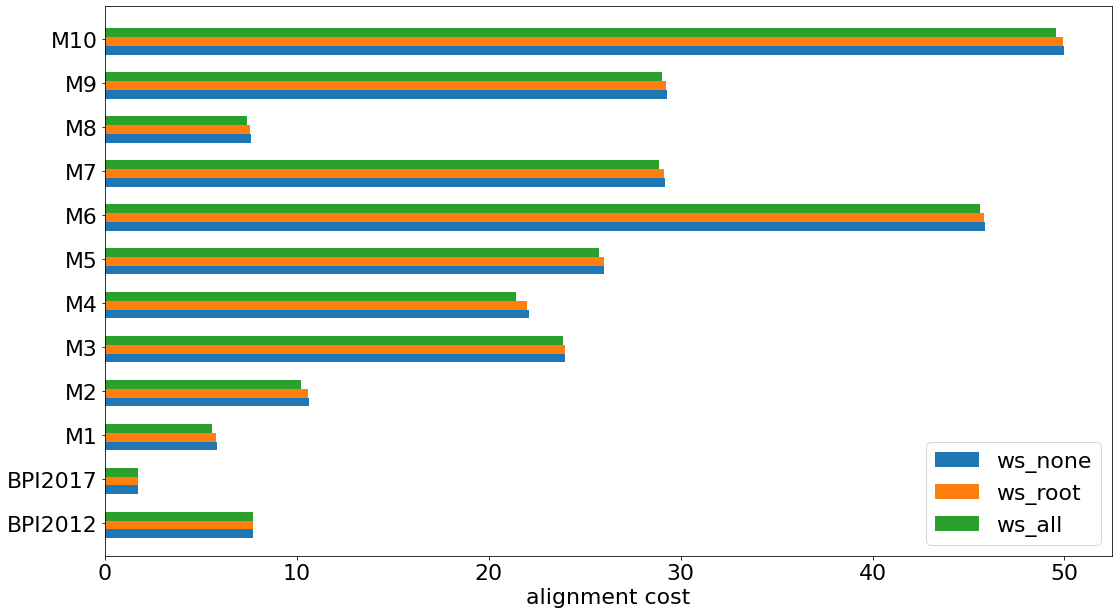

ws root stats:
ws root: mean mean all logs 21.626 - IWS: mean mean all logs 21.658
ws root: mean std all logs 14.62 - IWS: mean std all logs 14.62
Decrease % in conformance: -0.148
--------------------------------------------------------------------------------
ws all stats:
ws all: mean mean all logs 21.386 - IWS: mean mean all logs 21.658
ws all: mean std all logs 14.571 - IWS: mean std all logs 14.62
Decrease % in conformance: -1.256


<Figure size 432x288 with 0 Axes>

In [21]:
""" grouped bar chart ws root """
plt.rcParams.update({'font.size': 22})
plot_bar_chart_comparison_(validation.normal_labels, no_compl_no_conf_compl_stats,
                          no_conf_ws_root_stats, no_conf_ws_all_stats, 'mean', ['ws_none', 'ws_root', 'ws_all'], "alignment cost", "avg alignment cost pr log")

print("ws root stats:")
print_stat('mean', no_conf_ws_root_stats, no_compl_no_conf_compl_stats, "ws root", "IWS")
print_stat('std', no_conf_ws_root_stats, no_compl_no_conf_compl_stats,  "ws root", "IWS")
print(print_procentual('mean','conformance',no_conf_ws_root_stats, no_compl_no_conf_compl_stats))
print(40*"--")
print("ws all stats:")
print_stat('mean', no_conf_ws_all_stats, no_compl_no_conf_compl_stats, "ws all", "IWS")
print_stat('std', no_conf_ws_all_stats, no_compl_no_conf_compl_stats,  "ws all", "IWS")
print(print_procentual('mean','conformance',no_conf_ws_all_stats, no_compl_no_conf_compl_stats))

plt.savefig("images/avg alignment cost pr log - all logs.pdf")
#plt.show()
#plt.close()

##### Mean execution time comparison

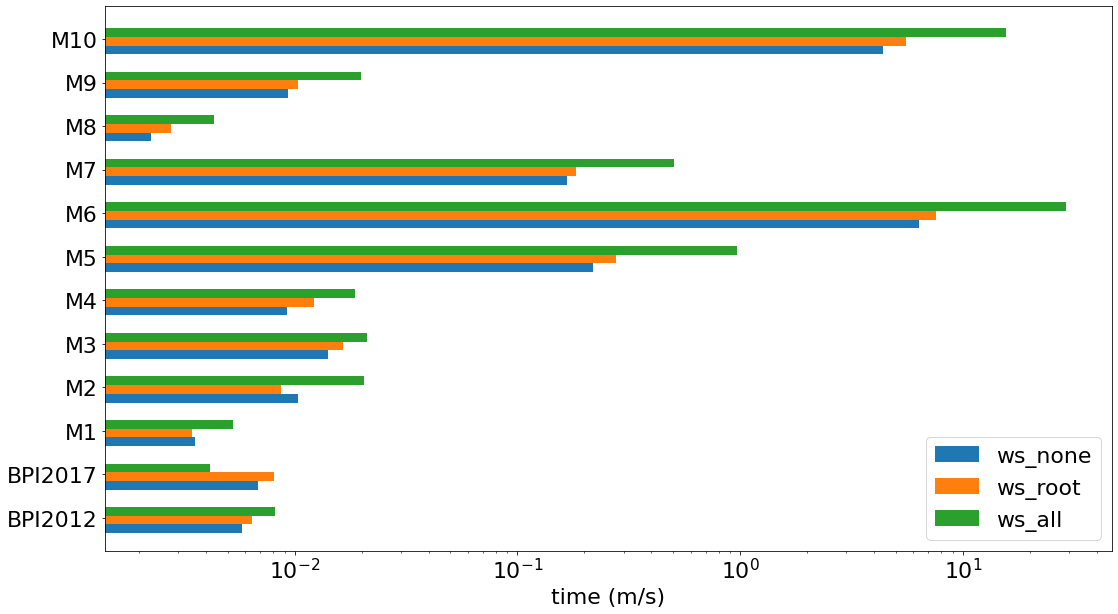

ws root stats:
ws root: mean time all logs 1.141 - IWS: mean time all logs 0.936
ws root: mean time_std all logs 0.398 - IWS: mean time_std all logs 0.328
--------------------------------------------------------------------------------
ws all stats:
ws all: mean time all logs 3.848 - IWS: mean time all logs 0.936
ws all: mean time_std all logs 1.941 - IWS: mean time_std all logs 0.328
--------------------------------------------------------------------------------
ws_root time comparison with standard - Increase % in time: 21.902
--------------------------------------------------------------------------------
ws_all time comparison with standard - Increase % in time: 311.111
--------------------------------------------------------------------------------
ws_all time comparison with ws_root - Increase % in time: 237.248


<Figure size 432x288 with 0 Axes>

In [22]:
plt.rcParams.update({'font.size': 22})
plot_bar_chart_comparison_(validation.normal_labels, no_compl_no_conf_compl_stats,
                          no_conf_ws_root_stats, no_conf_ws_all_stats,'time', ['ws_none', 'ws_root', 'ws_all'], "time (m/s)", "avg miliseconds pr event in log", True)

print("ws root stats:")
print_stat('time', no_conf_ws_root_stats, no_compl_no_conf_compl_stats, "ws root", "IWS")
print_stat('time_std', no_conf_ws_root_stats, no_compl_no_conf_compl_stats,  "ws root", "IWS")
print(40*"--")
print("ws all stats:")
print_stat('time', no_conf_ws_all_stats, no_compl_no_conf_compl_stats, "ws all", "IWS")
print_stat('time_std', no_conf_ws_all_stats, no_compl_no_conf_compl_stats,  "ws all", "IWS")
print(40*"--")
print("ws_root time comparison with standard - "+print_procentual('time','time',no_conf_ws_root_stats, no_compl_no_conf_compl_stats))
print(40*"--")
print("ws_all time comparison with standard - "+print_procentual('time','time',no_conf_ws_all_stats, no_compl_no_conf_compl_stats))
print(40*"--")
print("ws_all time comparison with ws_root - "+print_procentual('time','time',no_conf_ws_all_stats, no_conf_ws_root_stats))

plt.savefig("images/avg miliseconds pr event in log - all logs.pdf")
#plt.show()
#plt.close()

#### Kristo

Further down in the time and memory evaluation - it is shown how correlated alignment length and execution time is. Both M6 and M10 contains alignments in the hundreds.

### Confidence

In [ ]:
dims_14 = {'conf': 1, 'trace_length': 2, 'time': 3}
avg_costs_14 = {'conf': [], 'trace_length': [], 'time': []}

dims_25 = {'conf': 1, 'compl': 2, 'confi': 3, 'total': 4, 'trace_length': 5, 'time': 6}
avg_costs_25 = {'conf': [], 'compl': [], 'confi': [], 'total': [], 'trace_length': [], 'time': []}

no_compl_no_conf_dict, dict_keys = get_dataset_metrics(
   INPUT_DIR+"/tripleocc_runs/no_compl_no_conf", dims=dims_14, avg_costs=avg_costs_14, regex_f=extract_filename)
# no_compl_avg_dict, _ = get_dataset_metrics(
#     INPUT_DIR+"/tripleocc_runs/no_compl_avg", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
# no_compl_min_dict, _ = get_dataset_metrics(
#     INPUT_DIR+"/tripleocc_runs/no_compl_min", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
no_conf_ws_root_dict, dict_keys_ = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_conf_ws_root", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
no_conf_ws_all_states_dict, _  = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_conf_ws_all_compressed", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)

In [ ]:
# no_compl_no_conf_conf_stats = get_statistics(no_compl_no_conf_dict, validation.confidence_output)
# no_compl_avg_conf_stats = get_statistics(no_compl_avg_dict, validation.confidence_output)
# no_compl_min_conf_stats = get_statistics(no_compl_min_dict, validation.confidence_output)

In [ ]:
# """Grouped bar chart - confidence average"""

# plot_bar_chart_comparison(validation.confidence_output, no_compl_no_conf_conf_stats,
#                           no_compl_avg_conf_stats, 'mean', ['standard', 'avg'], "alignment cost", "avg alignment cost pr log")

# print("no completeness avg conf stats:")
# print_stat('mean', no_compl_avg_conf_stats, no_compl_no_conf_conf_stats, "avg conf", "IWS")
# print_stat('std', no_compl_avg_conf_stats, no_compl_no_conf_conf_stats,  "avg conf", "IWS")
# print_procentual('mean','conformance',no_compl_avg_conf_stats, no_compl_no_conf_conf_stats)


In [ ]:
# plot_bar_chart_comparison(validation.confidence_output, no_compl_no_conf_conf_stats,
#                           no_compl_min_conf_stats, 'mean', ['standard', 'min'], "alignment cost", "avg alignment cost pr log")

# print("no completeness min conf stats:")
# print_stat('mean', no_compl_min_conf_stats, no_compl_no_conf_conf_stats, "min conf", "IWS")
# print_stat('std', no_compl_min_conf_stats, no_compl_no_conf_conf_stats,  "min conf", "IWS")
# print_procentual('mean','conformance',no_compl_min_conf_stats, no_compl_no_conf_conf_stats)

## Stress test

- Operating system: Windows 11 Home 64-bit
- Processor: AMD Ryzen 7 5800 8-Core Processor (16 CPUs) ~3.4 GHz
- Memory: 16384MB RAM

Stress test was carried out by running each algorithm on the datasets 5 times and averaging the execution times to level out system resource interference while running the experiments.


### Average computation time per trace

In [ ]:
C_3PA_test = C_3PA_df.copy()[~C_3PA_df.log_type.isin(COMPLETENESS_LOGS)]
pref_w_1_test = pref_w_1_df.copy()[~pref_w_1_df.log_type.isin(COMPLETENESS_LOGS)]
pref_w_inf_test = pref_w_inf_df.copy()[~pref_w_inf_df.log_type.isin(COMPLETENESS_LOGS)]
BP_test = BP_df.copy()[~BP_df.log_type.isin(COMPLETENESS_LOGS)]
hmmconf_test = hmmconf_df.copy()[~hmmconf_df.log_type.isin(COMPLETENESS_LOGS)]

In [ ]:
print("Validating preprocessing after filtering out log types:")
print("hmmconf: {}".format(hmmconf_test.log_type.unique()))
print("BP_test: {}".format(BP_test.log_type.unique()))
print("C-3PO_test: {}".format(C_3PA_test.log_type.unique()))
print("W-1: {}".format(pref_w_1_test.log_type.unique()))
print("W-inf: {}".format(pref_w_inf_test.log_type.unique()))

In [ ]:
to_use = [C_3PA_test, pref_w_1_test, pref_w_inf_test, BP_test]
names_ = ['C_3PA_test', 'pref_w_1_test', 'pref_w_inf_test', 'BP_test']

t_ = dict()
for n_, df_ in list(zip(names_, to_use)):
    t_[n_] = list()
    for log_n in HMMCONF_LOGS:
        to_keep = hmmconf_test[hmmconf_test.model == log_n].TraceId.unique()
        df__ = df_[df_.model == log_n]
        df__ = df__[df__.TraceId.isin(to_keep)]
        df_ = df_[df_.model != log_n]
        t_[n_].append(df__)
    df_ = pd.concat(t_[n_] + [df_], ignore_index=True)

In [ ]:
print("Validating preprocessing after filtering out traces not in hmmconf")
print("hmmconf: {}".format(hmmconf_df.model.unique()))
print("BP_test: {}".format(BP_test.model.unique()))
print("C-3PO_test: {}".format(C_3PA_test.model.unique()))
print("W-1: {}".format(pref_w_1_test.model.unique()))
print("W-inf: {}".format(pref_w_inf_test.model.unique()))

In [ ]:
from functools import reduce

hmmconf_mean_exe = hmmconf_test.groupby(['model','TraceId']).agg({'ExecutionTime': np.sum}).groupby(['model']).agg({'ExecutionTime': np.mean}).reset_index()
BP_mean_exe = BP_test.groupby(['model','TraceId']).agg({'ExecutionTime': np.sum}).groupby(['model']).agg({'ExecutionTime': np.mean}).reset_index()
C_3PA_mean_exe = C_3PA_test.groupby(['model']).agg({'ExecutionTime': np.mean}).reset_index()
pref_w_inf_mean_exe = pref_w_inf_test.groupby(['model']).agg({'ExecutionTime': np.mean}).reset_index()
pref_w_1_mean_exe = pref_w_1_test.groupby(['model']).agg({'ExecutionTime': np.mean}).reset_index()

dfs = [hmmconf_mean_exe, BP_mean_exe, C_3PA_mean_exe, pref_w_inf_mean_exe, pref_w_1_mean_exe]

with io.capture_output() as captured:
    final_df = reduce(lambda  left,right: pd.merge(left,right,on=['model'],
                                            how='outer'), dfs);

indexes = final_df.model.values
columns = ['HMMCONF','BP','C-3PA','W-inf','W-1']

In [ ]:
def highlight_min(s):
    is_max = s == s.min()
    return ['color: green' if cell else '' for cell in is_max]

def highlight_2ndmin(s):
    is_max = s == s.nsmallest(2).iloc[-1]
    return ['color: yellow' if cell else '' for cell in is_max]

def highlight_3rdmin(s):
    is_max = s == s.nsmallest(3).iloc[-1]
    return ['color: red' if cell else '' for cell in is_max]


msg = "green = minimum trace execution time in row \n\
yellow = 2nd smallest execution time in row \n\
red = 3rd smallest execution time in row"

results = pd.DataFrame(index=indexes, data=final_df.iloc[:, 1:final_df.shape[1]].values, columns=columns).sort_index()
temp = results.loc['M10']
results = results.drop(index='M10')

with io.capture_output() as captured:
    results = results.append(temp)
    
print(msg)

results.style.apply(highlight_min, axis=1).apply(highlight_2ndmin, axis=1).apply(highlight_3rdmin, axis=1)

### Time and Memory

#### Cases buffer limit 10000

There are total 9778 cases in the log. Thus all cases are tracked during the whole execution in the buffer.

In [ ]:
stress_test_time = pd.read_csv(os.path.join('..', 'stress-test-data','results_cases_10000.csv'))
stress_test_time = stress_test_time.rename(columns={'MemorySizeTraces':'TotalUsedMem', 'MemorySizeCases':'MemUsedPerEvent'})
stress_test_time.ExecutionTime = stress_test_time.ExecutionTime / 1000000
stress_test_time.TotalUsedMem = stress_test_time.TotalUsedMem / 1000000
stress_test_time.MemUsedPerEvent = stress_test_time.MemUsedPerEvent / 1000000
stress_test_time.drop(0);

In [ ]:
(pd.to_datetime(stress_test_time.Time.iloc[-1]) - pd.to_datetime(stress_test_time.Time.iloc[0])).seconds

In [ ]:
(pd.to_datetime(stress_test_time.Time.iloc[-1]) - pd.to_datetime(stress_test_time.Time.iloc[0])).seconds * 1000 / stress_test_time.shape[0]

In [ ]:
stress_test_time.corr(method='spearman')

In [ ]:
stress_test_time.describe()

In [ ]:
np.argmax(stress_test_time.ExecutionTime.values);

In [ ]:
np.argmax(stress_test_time['Total states'].values);

In [ ]:
np.argmax(stress_test_time['Alignment length'].values);

In [ ]:
stress_test_time.iloc[1897815:,];

In [ ]:
stress_test_time.iloc[2002996:,];

##### Execution time

In [ ]:
plt.rcParams.update({'font.size': 20})

x = np.arange(stress_test_time.shape[0])

fig, ax = plt.subplots(figsize=(14,8))

ax1 = ax.twinx()
ax2 = ax.twinx()

p1, = ax.plot(stress_test_time.ExecutionTime.rolling(10000).mean(), 'b-', label="Execution time per event - SMA (10)")
p2, = ax1.plot(stress_test_time['Total cases'], 'r--', label="Tracked cases")
p3, = ax2.plot(stress_test_time['Alignment length'].rolling(10000).mean(), 'g-', label="Alignment length - SMA (10000)")

ax.set_xlabel('Events')
ax.set_ylabel('Time (m/s)')

ax1.set_ylabel('No of tracked cases in buffer')
ax2.set_ylabel("Alignment length")

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)

ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(0, 1.35, 1, 0), loc=2)
ax2.spines.right.set_position(("axes", 1.2))

fig.tight_layout()
#plt.title("Stress test")
plt.savefig("images/cases 10000 - execution time, tracked cases, alignment length.pdf")
plt.show()


In [ ]:
# align_ = stress_test_time[['Total states','ExecutionTime','Alignment length']]

# sns.kdeplot(data=align_[['Alignment length']], x='Alignment length', common_norm=False);
# plt.ylabel("Execution time density")
# plt.xlabel("Alignment Length")
# #plt.title("Conformance cost distribution on cases");

# plt.savefig("images/real life data set - conformance cost dist.pdf")
# plt.show()

In [ ]:
avg_quesize = stress_test_time.groupby('Alignment length').agg({'Total states':np.mean, 'ExecutionTime':np.mean})
x = np.arange(avg_quesize.shape[0])

fig, ax1 = plt.subplots(figsize=(10,5))

poly_fn = Polynomial.fit(x, avg_quesize['Total states'].values, 5)
y = poly_fn(x)

ax1.set_xlabel('Alignment length')
ax1.set_ylabel('Avg. states in case buffer')
#p1, = ax1.plot(y, 'b-', label="Avg. states in case buffer - polynominal fit (deg=5)")
p1, = ax1.plot(avg_quesize.index, avg_quesize['Total states'].rolling(10).mean(), label='Avg. states in case buffer - SMA(10)');

poly_fn = Polynomial.fit(x, avg_quesize['ExecutionTime'].values, 5)
y = poly_fn(x)

ax2 = ax1.twinx()
#p2, = ax2.plot(y, color='red', label='Avg. execution time - polynominal fit (deg=5)');
p2, = ax2.plot(avg_quesize.index, avg_quesize['ExecutionTime'].rolling(10).mean(), color='red', label='Avg. execution time - SMA(10)');
ax2.set_ylabel('Time (m/s)')

ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)

ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)

ax1.legend(handles=[p1, p2], bbox_to_anchor=(0, 1.25, 1, 0), loc=2)
ax2.spines.right.set_position(("axes", 1.))

fig.tight_layout()
#plt.title('Alignment length vs avg. states in case buffer and avg. execution time')
plt.xlabel('Alignment Length')
plt.savefig("images/cases 10000 - alignment length vs states in case buffer and avg execution time.pdf")
plt.show()


In [ ]:
# avg_quesize = stress_test_time_old.groupby('Alignment length').agg({'Total states':np.mean, 'ExecutionTime':np.mean})
# x = np.arange(avg_quesize.shape[0])

# fig, ax1 = plt.subplots(figsize=(10,5))

# poly_fn = Polynomial.fit(x, avg_quesize['Total states'].values, 5)
# y = poly_fn(x)

# ax1.set_xlabel('Alignment length')
# ax1.set_ylabel('Avg. states in case buffer')
# #p1, = ax1.plot(y, 'b-', label="Avg. states in case buffer - polynominal fit (deg=5)")
# p1, = ax1.plot(avg_quesize.index, avg_quesize['Total states'].rolling(10).mean(), label='Avg. states in case buffer - SMA(10)');

# poly_fn = Polynomial.fit(x, avg_quesize['ExecutionTime'].values, 5)
# y = poly_fn(x)

# ax2 = ax1.twinx()
# #p2, = ax2.plot(y, color='red', label='Avg. execution time - polynominal fit (deg=5)');
# p2, = ax2.plot(avg_quesize.index, avg_quesize['ExecutionTime'].rolling(10).mean(), color='red', label='Avg. execution time - SMA(10)');
# ax2.set_ylabel('Time (m/s)')

# ax1.yaxis.label.set_color(p1.get_color())
# ax2.yaxis.label.set_color(p2.get_color())

# tkw = dict(size=4, width=1.5)

# ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
# ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
# ax1.tick_params(axis='x', **tkw)

# ax1.legend(handles=[p1, p2], bbox_to_anchor=(0, 1.2, 1, 0), loc=2)
# ax2.spines.right.set_position(("axes", 1.))

# fig.tight_layout()
# #plt.title('Alignment length vs avg. states in case buffer and avg. execution time')
# plt.xlabel('Alignment Length')
# plt.savefig("images/cases 10000 - alignment length vs states in case buffer and avg execution time.pdf")
# plt.show()


In [ ]:
rho_time_alg = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time['Total cases'], stress_test_time['ExecutionTime'])
rho_time_states = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Total states'])

print(
    'Correlation between the measured quantities:',
    '\nExecution time - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nExecution time - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nExecution time - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

Intrepretation:

- As expected the execution time is correlated correlated with the states in the states buffer, which can also be discerned from the plot "Alignment length vs avg. states in case buffer and avg. execution time". The dips in 'Avg. states in case buffer' can be intrepreted as it drops due to decay time (0.3).

- Execution time and alignment length display a positive trend - as the correllation metric shows they are highly correlated.

- Cases in states buffer is also showing a positive correlation with execution time ("Stress test figure"), but it is not as evident from the first plot as the execution time lags behind the increase in buffered cases for some time.

##### Memory usage

In [ ]:
plt.rcParams.update({'font.size': 20})

x = np.arange(stress_test_time.shape[0])

fig, ax = plt.subplots(figsize=(14,9))
ax2 = ax.twinx()

n = 10000
p1, = ax.plot([x + n - 1 for x in range(0, stress_test_time.shape[0], n)], stress_test_time.TotalUsedMem.iloc[0:-1:n], 'b-', label="Memory usage - SMA (10000)")

# poly_fn = Polynomial.fit(x, stress_test_time.TotalUsedMem.values, 1)
# y = poly_fn(x)
# p1, = ax.plot(y, 'b-', label="Memory usage - polynominal fit (deg=1)")

poly_fn = Polynomial.fit(x, stress_test_time.MemUsedPerEvent.values, 1)

y = poly_fn(x)

p3, = ax2.plot(y, 'r-', label="Memory usage per event - polynominal fit (deg=1)")

n = 5000
p2, = ax2.plot([x + n - 1 for x in range(0, stress_test_time.shape[0], n)], stress_test_time.MemUsedPerEvent.rolling(10000).mean().iloc[0:-1:n], 'g+', label="Memory usage per event - SMA (10000)")

ax.set_xlabel('Events')
ax.set_ylabel('Space (MB)')
ax2.set_ylabel('Space (MB)')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)

ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(0, 1.28, 1, 0), loc=2)
ax2.spines.right.set_position(("axes", 1.))

fig.tight_layout()
#plt.title("Stress test - memory usage")
plt.savefig("images/cases 10000 - memory usage, memory usage per event.pdf")
plt.show()


In [ ]:
rho_time_alg = stats.spearmanr(stress_test_time.TotalUsedMem, stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time.TotalUsedMem, stress_test_time['Total cases'])
rho_time_states = stats.spearmanr(stress_test_time.TotalUsedMem, stress_test_time['Total states'])

print(
    'Correlation between the measured quantities:',
    '\nMemory in use at runtime - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nMemory in use at runtime - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nMemory in use at runtime - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

Intrepretation:

- From the plot above - "Stress test - memory usage", we see a clear trend between the total space usage and the increase in alignment lengths, stored in the state buffers. It is shown also by the correlation coeffcient which determines a strong positive correlation between the two quantities.

- The negative correlation to stored states, indicates the decay time, which can be seen from "Alignment length vs avg. states in case buffer and avg. execution time" is reducing the stored states wereas memory usage is increasing due to the alignments.


In [ ]:
rho_time_alg = stats.spearmanr(stress_test_time.MemUsedPerEvent, stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time.MemUsedPerEvent, stress_test_time['Total cases'])
rho_time_states = stats.spearmanr(stress_test_time.MemUsedPerEvent, stress_test_time['Total states'])

print(
    'Correlation between the measured quantities:',
    '\nMemory used per event - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nMemory used per event - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nMemory used per event - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

Intrepretation:

- We see now that the memory per event usage is positively correlated with number of states in the states buffer, which is to be expected as the algorithm visits more states to compute new alignments from.

#### Kristo

Just want to share that this was the correlation before the introduced criteria to limiting warm-start nodes:
- Memory used per event - states size: spearman rho: 0.725


#### Cases buffer limit 5000

A key thing to note is that, and correct me if I'm wrong, but there is 1000 cases in the BPI_logs and 500 in each of the Mx_logs. Here we will see the effect of reducing the number of cases on memory and time which will reduce the cases as there is 9778 cases in the stream file.

In [ ]:
# stress_test_time.Time = stress_test_time.Time.apply(lambda x: pd.Timestamp(x).second);

In [ ]:
# test = stress_test_time.groupby('Time')[['Total states','Total cases','Alignment length','ExecutionTime','MemUsedPerEvent','TotalUsedMem']].agg({np.mean})

In [ ]:
stress_test_time = pd.read_csv(os.path.join('..', 'stress-test-data','results_cases_5000.csv'))
stress_test_time = stress_test_time.rename(columns={'MemorySizeTraces':'TotalUsedMem', 'MemorySizeCases':'MemUsedPerEvent'})
stress_test_time.ExecutionTime = stress_test_time.ExecutionTime / 1000000
stress_test_time.TotalUsedMem = stress_test_time.TotalUsedMem / 1000000
stress_test_time.MemUsedPerEvent = stress_test_time.MemUsedPerEvent / 1000000
stress_test_time.drop(0);

In [ ]:
stress_test_time.describe()

##### Execution time

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(14,8))

ax1 = ax.twinx()
ax2 = ax.twinx()

n = 10000
p1, = ax.plot([x + n - 1 for x in range(0, stress_test_time.shape[0], n)], stress_test_time.ExecutionTime.rolling(10).mean().iloc[0:-1:n], 'b-', label="Execution time per event - SMA (10)")

p2, = ax1.plot(stress_test_time['Total cases'], 'r--', label="Tracked cases")

n = 10000
p3, = ax2.plot([x + n - 1 for x in range(0, stress_test_time.shape[0], n)], stress_test_time['Alignment length'].rolling(1).mean().iloc[0:-1:n], 'g', label="Alignment length - SMA (10000)")

ax.set_xlabel('Events')
ax.set_ylabel('Time (m/s)')

ax1.set_ylabel('No of tracked cases in buffer')
ax2.set_ylabel("Alignment length")

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)

ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(0, 1.35, 1, 0), loc=2)
ax2.spines.right.set_position(("axes", 1.2))

fig.tight_layout()
plt.savefig("images/cases 5000 - execution time, tracked cases, alignment length.pdf")
plt.show()


In [ ]:
avg_quesize = stress_test_time.groupby('Alignment length').agg({'Total states':np.mean, 'ExecutionTime':np.mean})
x = np.arange(avg_quesize.shape[0])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Alignment length')
ax1.set_ylabel('Avg. states in case buffer')
# poly_fn = Polynomial.fit(x, avg_quesize['Total states'].values, 5)
# y = poly_fn(x)
# p1, = ax1.plot(y, 'b-', label="Avg. states in case buffer - polynominal fit (deg=5)")
p1, = ax1.plot(avg_quesize.index, avg_quesize['Total states'].rolling(10).mean(), label='Avg. states in case buffer - SMA(10)');

ax2 = ax1.twinx()
# poly_fn = Polynomial.fit(x, avg_quesize['ExecutionTime'].values, 5)
# y = poly_fn(x)
# p2, = ax2.plot(y, color='red', label='Avg. execution time - polynominal fit (deg=5)');
p2, = ax2.plot(avg_quesize.index, avg_quesize['ExecutionTime'].rolling(10).mean(), color='red', label='Avg. execution time - SMA(10)');
ax2.set_ylabel('Time (m/s)')

ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)

ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)

ax1.legend(handles=[p1, p2], bbox_to_anchor=(0, 1.2, 1, 0), loc=2)
ax2.spines.right.set_position(("axes", 1.))

fig.tight_layout()
#plt.title('Alignment length vs avg. states in case buffer and avg. execution time')
plt.xlabel('Alignment Length')
plt.savefig("images/cases 5000 - alignment length vs states in case buffer and avg execution time.pdf")
plt.show()


In [ ]:
rho_time_alg = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Total cases'])
rho_time_states = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Total states'])

print(
    'Correlation between the measured quantities:',
    '\nExecution time - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nExecution time - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nExecution time - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

##### Memory usage

In [ ]:
x = np.arange(stress_test_time.shape[0])

fig, ax = plt.subplots(figsize=(10,5))

# poly_fn = Polynomial.fit(x, stress_test_time.TotalUsedMem.values, 5)
# y = poly_fn(x)
# p1, = ax.plot(y, 'b-', label="Memory usage - polynominal fit - degree 5")
n = 10000
p1, = ax.plot([x + n - 1 for x in range(0, stress_test_time.shape[0], n)], stress_test_time.TotalUsedMem.iloc[0:-1:n], 'b-', label="Memory usage - SMA (10000)")

ax2 = ax.twinx()
n = 10000
p2, = ax2.plot([x + n - 1 for x in range(0, stress_test_time.shape[0], n)], stress_test_time.MemUsedPerEvent.rolling(10000).mean().iloc[0:-1:n], 'g+', label="Memory usage per event - SMA (10000)")

poly_fn = Polynomial.fit(x, stress_test_time.MemUsedPerEvent.values, 1)
y = poly_fn(x)
p3, = ax2.plot(y, 'r-', label="Memory usage per event - polynominal fit - degree 1")
# n = 15000
# p3, = ax2.plot([x + n - 1 for x in range(0, x.shape[0], n)], y[0:-1:n], 'r-', label="Memory usage per event - polynominal fit - degree 1")

ax.set_xlabel('Events')
ax.set_ylabel('Space (MB)')
ax2.set_ylabel('Space (MB)')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)

ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(0, 1.3, 1, 0), loc=2)
ax2.spines.right.set_position(("axes", 1.))

fig.tight_layout()
#plt.title("Stress test - memory usage")
plt.savefig("images/cases 5000 - memory usage, memory usage per event.pdf")
plt.show()


In [ ]:
rho_time_alg = stats.spearmanr(stress_test_time.TotalUsedMem, stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time.TotalUsedMem, stress_test_time['Total cases'])
rho_time_states = stats.spearmanr(stress_test_time.TotalUsedMem, stress_test_time['Total states'])

print(
    'Correlation between the measured quantities:',
    '\nMemory in use at runtime - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nMemory in use at runtime - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nMemory in use at runtime - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

In [ ]:
rho_time_alg = stats.spearmanr(stress_test_time.MemUsedPerEvent, stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time.MemUsedPerEvent, stress_test_time['Total cases'])
rho_time_states = stats.spearmanr(stress_test_time.MemUsedPerEvent, stress_test_time['Total states'])

print(
    'Correlation between the measured quantities:',
    '\nMemory used per event - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nMemory used per event - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nMemory used per event - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

Intrepretation:

- No strong correlation between memory in use and alignment length. In general the correlation coefficient between the measured quantities show no monotonic relationship. It can be infered that as long as the size of the case buffer is kept within a capacity the influence of the factors that grows memory are negligble.

## Confusion Matrix

In [ ]:
from sklearn import metrics
plt.rcParams.update({'font.size': 17})
C_3PA_ = C_3PA_df.copy()[['Conformance cost']][C_3PA_df.model.isin(PREF_W_INF_LOGS)]
pref_w_inf_ = pref_w_inf_df.copy()[['Conformance cost']]
pref_w_1_ = pref_w_1_df.copy()[['Conformance cost']]

In [ ]:
print("C-3PA and W-inf")

C_3PA_['Conformance cost'] = C_3PA_['Conformance cost'].apply(lambda x : True if x > 0 else False)
pref_w_inf_['Conformance cost'] = pref_w_inf_['Conformance cost'].apply(lambda x : True if x > 0 else False)

confusion_matrix = metrics.confusion_matrix(pref_w_inf_.values, C_3PA_.values)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.yticks([0,1],rotation=90)
plt.xlabel('Not conforming for C-3PA')
plt.ylabel('Not conforming for W-inf')
plt.tight_layout()
plt.savefig("images/confusion matrix - win-inf.png")
plt.show()

In [ ]:
print("Balanced accuracy score: https://en.wikipedia.org/wiki/Precision_and_recall")
print(metrics.balanced_accuracy_score(pref_w_inf_.values, C_3PA_.values))

In [ ]:
print("C-3PA and W-1")

pref_w_1_['Conformance cost'] = pref_w_1_['Conformance cost'].apply(lambda x : True if x > 0 else False)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.yticks([0,1],rotation=90)
plt.xlabel('Not conforming for C-3PA')
plt.ylabel('Not conforming for W-1')
plt.tight_layout()
plt.savefig("images/confusion matrix - w-1.png")
plt.show()


In [ ]:
print("Balanced accuracy score:")
metrics.balanced_accuracy_score(pref_w_1_.values, C_3PA_.values)

## Correlation test

### Spearman correlation with non-conforming results



#### HMMCONF

In [ ]:
C_3PA_test = C_3PA_df.copy()[C_3PA_df.model.isin(HMMCONF_LOGS)]
#C_3PA_test = C_3PA_test[~C_3PA_test.log_type.isin(COMPLETENESS_LOGS)]
#hmmconf_test = hmmconf_test[~hmmconf_test.log_type.isin(COMPLETENESS_LOGS)]

dfs= list()
for log_n in HMMCONF_LOGS:
    to_keep = hmmconf_test[hmmconf_test.model == log_n].TraceId.unique()
    df__ = C_3PA_test[C_3PA_test.model == log_n]
    df__ = df__[df__.TraceId.isin(to_keep)]
    dfs.append(df__)
C_3PA_test = pd.concat(dfs, ignore_index=True)

hmmconf_mean_conf_compl = hmmconf_df.groupby(['model','log_type','TraceId']).agg({'finalconf': np.mean, 'completeness': np.mean, 'injected_distance': np.mean}).reset_index()

merged_df = pd.merge(hmmconf_mean_conf_compl, C_3PA_test, on=['model','log_type','TraceId'])

pred1 = merged_df['Conformance cost'] > 0
pred2 = merged_df['finalconf'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conf_mean_finalconf = stats.spearmanr(filtered_df['Conformance cost'], filtered_df['finalconf'])
rho_conf_compl = stats.spearmanr(filtered_df['Conformance cost'], filtered_df['injected_distance'])
rho_compl_injected_distance = stats.spearmanr(filtered_df['Completeness cost'], filtered_df['injected_distance'])
rho_completeness = stats.spearmanr(filtered_df['Completeness cost'], filtered_df['completeness'])

print(
    'Conformance cost - mean final conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_mean_finalconf[0], rho_conf_mean_finalconf[1]),
    '\nConformance cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
    '\nCompleteness cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_compl_injected_distance[0], rho_compl_injected_distance[1]),
    '\nCompleteness cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

##### Remarks

Conformance cost - mean final conformance:
- Conformance cost and mean conformance show an inversly proportional relationship which is expected as a conformance value closer to 1 signifies that the trace is conforming to the reference model

Completeness cost - injected distance:
- Slight positive correlation which is meaningful as completeness cost and injected distance can be induced from missing tail of trace

Completeness cost:
- Similar to conformance cost and mean conformance, completeness cost and completeness share an inversly proportional relationship - correlation greater than with injected distance



#### W-1

In [ ]:
C_3PA_ = C_3PA_df.copy()[['TraceId', 'Completeness cost', 'Conformance cost', 'Confidence cost', 'model', 'log_type']][C_3PA_df.model.isin(PREF_W_1_LOGS)]
#C_3PA_ = C_3PA_[~C_3PA_.log_type.isin(COMPLETENESS_LOGS)]
C_3PA_ = C_3PA_.rename(columns={'Conformance cost':'C_3PA_conf'})

pref_w_1_ = pref_w_1_df.copy()
#pref_w_1_ = pref_w_1_[~pref_w_1_.log_type.isin(COMPLETENESS_LOGS)]
pref_w_1_ = pref_w_1_.rename(columns={'Conformance cost':'pref_w_1_conf'})


merged_df = pd.merge(C_3PA_, pref_w_1_, on=['model','log_type','TraceId'])

pred1 = merged_df['C_3PA_conf'] > 0
pred2 = merged_df['pref_w_1_conf'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conf = stats.spearmanr(filtered_df['C_3PA_conf'], filtered_df['pref_w_1_conf'])
rho_conf_compl = stats.spearmanr(filtered_df['Completeness cost'],filtered_df['pref_w_1_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

##### Remarks

Conformance cost:
- Strong positive correlation between conformance cost in the two approaches over all traces in all logs.

Completeness cost:
- Expected positive correlation due to a higher completeness cost indicating that the trace was not observed from its begining. Thus should increase the alignment cost calculated with a conventional prefix-alignment algorithm, as it finds a path through the SPN from the starting marking. An explanation is that completeness indicates when the algorithm has to recalculated an suboptimal alignment by choosing another path in the trie. The resulting alignment costs less and taking into consideration with the strong correlation between the conformance cost of the two algorithms the corresponding alignment calculated by the SPN algorithm should be equally lower in cost.

#### W-inf

In [ ]:
C_3PA_ = C_3PA_df.copy()[['TraceId', 'Completeness cost', 'Conformance cost', 'Confidence cost', 'model', 'log_type']][C_3PA_df.model.isin(PREF_W_INF_LOGS)]
#C_3PA_ = C_3PA_[~C_3PA_.log_type.isin(COMPLETENESS_LOGS)]
C_3PA_ = C_3PA_.rename(columns={'Conformance cost':'C_3PA_conf'})

pref_w_inf_ = pref_w_inf_df.copy()
#pref_w_inf_ = pref_w_inf_[~pref_w_inf_.log_type.isin(COMPLETENESS_LOGS)]
pref_w_inf_ = pref_w_inf_.rename(columns={'Conformance cost':'pref_w_inf_conf'})

merged_df = pd.merge(C_3PA_, pref_w_inf_, on=['model','log_type','TraceId'])

pred1 = merged_df['C_3PA_conf'] > 0
pred2 = merged_df['pref_w_inf_conf'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conf = stats.spearmanr(filtered_df['C_3PA_conf'], filtered_df['pref_w_inf_conf'])
rho_conf_compl = stats.spearmanr(filtered_df['Completeness cost'],filtered_df['pref_w_inf_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

In [ ]:
# """ completeness only """

# print("Completeness logs only:")

# pred3 = filtered_df.log_type.isin(COMPLETENESS_LOGS)

# filtered_df = filtered_df.loc[pred3, :]

# rho_conf = stats.spearmanr(filtered_df['C_3PA_conf'], filtered_df['pref_w_inf_conf'])
# rho_conf_compl = stats.spearmanr(filtered_df['Completeness cost'],filtered_df['pref_w_inf_conf'])

# print(
#     'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
#     '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
# )

##### Remarks

Conformance cost:
- Stronger positive correlation between conformance cost than W-1.

Completeness cost:
- Slightly more correlation than with W-1. Can be intrepreted together with the also slightly higher correlation between conformance cost, that completeness represents a recovery from a bad prefix-alignment.


#### BP

In [ ]:
C_3PA_BP = C_3PA_df.copy()[['TraceId', 'Completeness cost', 'Conformance cost', 'Confidence cost', 'model', 'log_type','TraceLength']][C_3PA_df.model.isin(BP_LOGS)]
#C_3PA_BP = C_3PA_BP[~C_3PA_BP.log_type.isin(COMPLETENESS_LOGS)]

BP_mean = BP_df.groupby(['model','log_type','TraceId']).agg({'conformance': np.mean, 'completeness': np.mean, 'confidence': np.mean}).reset_index()
#BP_mean = BP_mean[~BP_mean.log_type.isin(COMPLETENESS_LOGS)]
merged_df = pd.merge(C_3PA_BP, BP_mean, on=['model','log_type','TraceId'])

pred1 = merged_df['Conformance cost'] > 0
pred2 = merged_df['conformance'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conformance = stats.spearmanr(filtered_df['Conformance cost'], filtered_df['conformance'])
rho_conformance_completeness = stats.spearmanr(filtered_df['Conformance cost'], filtered_df['completeness'])
rho_confidence = stats.spearmanr(filtered_df['Confidence cost'], filtered_df['confidence'])
rho_completeness = stats.spearmanr(filtered_df['Completeness cost'], filtered_df['completeness'])

print(
    'Conformance cost - mean conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance[0], rho_conformance[1]),
    '\nConformance cost - completeness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance_completeness[0], rho_conformance_completeness[1]), 
    '\nConfidence: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_confidence[0], rho_confidence[1]),
    '\nCompleteness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

 #### Remarks

Conformance cost - mean conformance:
- Higher correlation between conformance cost and conformance than with hmmconf. Same inverse relationship between the two metrics.

Conformance cost - completeness:
- Meaningfull as complete traces are longer than incomplete an thus the conformance cost will be greater.

Confidence:
- Similar relationship as with conformance cost and mean conformance. Higher confidence signals the opposite of high confidence in BP.

Completeness:
- Lesser but still expected negative correlation between the two metrics for the same reasons as with the other.

### Spearman correlation with all results

#### HMMCONF

In [ ]:
merged_df = pd.merge(hmmconf_mean_conf_compl, C_3PA_test, on=['model','log_type','TraceId'])

rho_conf_mean_finalconf = stats.spearmanr(merged_df['Conformance cost'], merged_df['finalconf'])
rho_conf_compl = stats.spearmanr(merged_df['Conformance cost'], merged_df['injected_distance'])
rho_compl_injected_distance = stats.spearmanr(merged_df['Completeness cost'], merged_df['injected_distance'])
rho_completeness = stats.spearmanr(merged_df['Completeness cost'], merged_df['completeness'])

print(
    'Conformance cost - mean final conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_mean_finalconf[0], rho_conf_mean_finalconf[1]),
    '\nConformance cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
    '\nCompleteness cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_compl_injected_distance[0], rho_compl_injected_distance[1]),
    '\nCompleteness cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

#### W-1

In [ ]:
merged_df = pd.merge(C_3PA_, pref_w_1_, on=['model','log_type','TraceId'])

rho_conf = stats.spearmanr(merged_df['C_3PA_conf'], merged_df['pref_w_1_conf'])
rho_conf_compl = stats.spearmanr(merged_df['Completeness cost'],merged_df['pref_w_1_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

#### W-inf

In [ ]:
merged_df = pd.merge(C_3PA_, pref_w_inf_, on=['model','log_type','TraceId'])

rho_conf = stats.spearmanr(merged_df['C_3PA_conf'], merged_df['pref_w_inf_conf'])
rho_conf_compl = stats.spearmanr(merged_df['Completeness cost'],merged_df['pref_w_inf_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

#### BP

In [ ]:
merged_df = pd.merge(C_3PA_BP, BP_mean, on=['model','log_type','TraceId'])

rho_conformance = stats.spearmanr(merged_df['Conformance cost'], merged_df['conformance'])
rho_conformance_completeness = stats.spearmanr(merged_df['Conformance cost'], merged_df['completeness'])
rho_confidence = stats.spearmanr(merged_df['Confidence cost'], merged_df['confidence'])
rho_completeness = stats.spearmanr(merged_df['Completeness cost'], merged_df['completeness'])

print(
    'Conformance cost - mean conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance[0], rho_conformance[1]),
    '\nConformance cost - completeness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance_completeness[0], rho_conformance_completeness[1]), 
    '\nConfidence: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_confidence[0], rho_confidence[1]),
    '\nCompleteness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

## Cumulitative plots

### W-1

In [ ]:
C_3PA_ = C_3PA_.rename(columns={'C_3PA_conf':'Conformance cost'})

pref_w_1_df['occ'] = len(pref_w_1_df) * ['W-1']
C_3PA_['occ'] = len(C_3PA_) * ['WS_all']

cumu_df = pd.concat([pref_w_1_df, C_3PA_])

sns.histplot(x='Conformance cost', data=cumu_df, hue='occ', bins=len(cumu_df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
#plt.title("Cumulative distribution function");
plt.tight_layout()
plt.savefig("images/cumulative plot - w-1.png")
plt.show()

#### Intrepretation

- lines are not crossing at ~0.5 which means the median of the two distributions is not the same.

### W-inf

In [ ]:
pref_w_inf_df['occ'] = len(pref_w_inf_df) * ['W-inf']

cumu_df = pd.concat([pref_w_inf_df, C_3PA_])

sns.histplot(x='Conformance cost', data=cumu_df, hue='occ', bins=len(cumu_df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
#plt.title("Cumulative distribution function");
plt.tight_layout()
plt.savefig("images/cumulative plot - w-inf.png")
plt.show()

#### Intrepretation

- lines are crossing at ~0.5 which means the median of the two distributions is the same.
- both plots exhibit an almost identical curve

In [ ]:
print("Cumulitative density plot on completeness logs")
cumu_df = cumu_df[cumu_df.log_type.isin(COMPLETENESS_LOGS)]

sns.histplot(x='Conformance cost', data=cumu_df, hue='occ', bins=len(cumu_df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
#plt.title("Cumulative distribution function - completeness logs only");
plt.tight_layout()
plt.savefig("images/cumulative plot - w-inf - completeness logs only.pdf")
plt.show()

In [ ]:
# Example:

# < H > is missing as a model move in the OCC

# size = 8 \
# Trace: {C,E,G,D,B,F,A,H}

# (>>,A):1.0  \
# (C,C):0.0 \
# (E,E):0.0 \
# (G,G):0.0 \
# (>>,H):1.0                  <--- \
# (>>,F):1.0 \
# (D,D):0.0 \
# (B,B):0.0 \
# (F,>>):1.0 \
# (A,>>):1.0 \
# (H,>>):1.0

# Total cost = 6
 
# [logMove:>>, modelMove:A, cost:1] \
# [logMove:C, modelMove:C, cost:0] \
# [logMove:E, modelMove:E, cost:0] \
# [logMove:G, modelMove:G, cost:0] \
# [logMove:D, modelMove:>>, cost:1] \
# [logMove:B, modelMove:>>, cost:1] \
# [logMove:F, modelMove:>>, cost:1] \
# [logMove:A, modelMove:>>, cost:1] \
# [logMove:H, modelMove:H, cost:0]

# Total cost:5

## Real life data set evaluation

In [ ]:
import os
import pm4py
from pm4py.util import constants
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.visualization.graphs import visualizer as graphs_visualizer

RL_DIR = os.path.join('..','real-life-dataset','Hospital Billing')

log_path = os.path.join(RL_DIR,"Hospital Billing - Event Log.xes")
log = pm4py.read_xes(log_path)

In [ ]:
""" case duration distribution """
x, y = case_statistics.get_kde_caseduration(log, parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

msg = "P4PY inbuilt function to plot kernel density case duration"
print(msg)

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

# gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
# graphs_visualizer.view(gviz)

plt.savefig("images/real life data set - case duration.pdf")
plt.show()

In [ ]:
result_path = os.path.join(RL_DIR, 'result.csv')
result_df = pd.read_csv(result_path)
result_df = result_df.rename(columns={
    ' Activity':'Activity',
    ' Conformance cost':'Conformance cost',
    ' Completeness cost':'Completeness cost',
    ' Confidence cost':'Confidence cost',
    ' total cost':'total cost',
    ' ExecutionTime_TRIE_STREAMING_C_3PA': 'ExecutionTime'
})

In [ ]:
""" removing noise categorized by high number of consecutive repeating activities """

t_ = result_df.groupby('TraceId')['Activity'].value_counts().groupby(level=0).head(1)
t_ = t_[t_ < 5]
idxs = t_.index.to_flat_index()
idxs = list(list(zip(*idxs))[0])
result_df = result_df.loc[result_df.TraceId.isin(idxs)]

""" removing short cases < 10 """
t_ = result_df.groupby('TraceId').agg(np.size)
t_ = t_[t_ > 10].dropna()
result_df = result_df.loc[result_df.TraceId.isin(t_.index.values)]

In [ ]:
msg = "removed noise categorized by high number of consecutive repeating activities with threshold 5\n\
removing short cases < 10"

print(msg)
print(90*"_")
result_df.info()

In [ ]:
""" non conforming cases """

result_ = result_df[result_df['Conformance cost'] > 0]

plt.figure(figsize=(15,10))
sns.boxplot(x='Activity', y='Conformance cost', data=result_.sort_values('Activity'));
plt.xticks(rotation=90)
#plt.title("Boxplot: activities alignment cost distribution on non conforming cases");
plt.savefig("images/real life data set - box plot.pdf")
plt.show()

In [ ]:
result__ = result_.groupby('TraceId')['Conformance cost'].agg({np.max})

sns.kdeplot(x=[val for li in result__.values for val in li], data=result__.index, common_norm=False);
plt.ylabel("Case density")
plt.xlabel("Conformance cost")
#plt.title("Conformance cost distribution on cases");

plt.savefig("images/real life data set - conformance cost dist.pdf")
plt.show()